In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse.linalg import svds
from sparsesvd import sparsesvd
from scipy.sparse import csr_matrix, csc_matrix
from sklearn.model_selection import train_test_split

In [2]:
df_watch = pd.read_csv('data/content_watch.csv')
df_rates = pd.read_csv('data/content_rates.csv')
test = pd.read_csv('data/test_set.csv')
df_watch = df_watch.rename(index=str, columns={"user_index": "user_id"})
df_rates = df_rates.rename(index=str, columns={"user_index": "user_id"})
test = test.rename(index=str, columns={"user_index": "user_id"})

## 1. Анализ данных

Посмотрим на данные:

In [3]:
df_watch.head()

,user_id,item_id,watch_duration
0,1677306600,2011099417,34.0
1,1677306600,-1495220568,11175.0
2,1677306600,1642882038,651.0
3,1677306600,742930742,1192.0
4,1677306600,-1068637190,8465.0


In [4]:
df_rates.head()

,user_id,item_id,rate
0,389298900,1515894657,10
1,389298900,-742253908,10
2,-631917800,-1660713173,10
3,124302000,1746724601,8
4,933344900,-1723773973,8


In [5]:
df_watch[['watch_duration']].describe()

,watch_duration
count,7.438820e+05
mean,9.044793e+03
std,2.740012e+04
min,0.000000e+00
25%,3.600000e+02
50%,2.648000e+03
75%,8.120750e+03
max,2.013658e+06


Видно, что разброс длительности просмотра большой, от 0 до десятков тысяч минут, в выборе явно есть многосерийный контент.

### Гистограмма распределения длительности просмотра

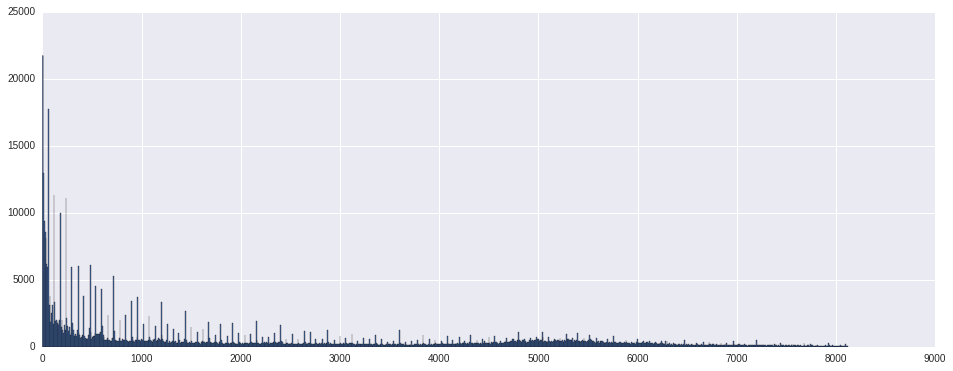

In [6]:
dur_min = df_watch.watch_duration.min()
dur_75q = df_watch.watch_duration.quantile(0.75)

plt.figure(figsize=(16, 6))
plt.hist(df_watch.watch_duration.dropna(), bins=1000, range=(dur_min, dur_75q))
plt.show()

На гистограмме видны скопления значений в начале оси (пользователи открывают контент и понимают, что это не то, что они хотели) и в районе значений в 5000-6000 секунд (~90-120 минут) - средняя длительность фильма, то есть фильмов достаточно много (сериалы обычно короче, либо их смотрят по много серий, тогда длительность будет намного больше).

Добавим признак - количество просмотренных пользователем айтемов за период:

In [7]:
df_watch['content_count_byuser'] = df_watch.groupby(df_watch['user_id'])['item_id'].transform('nunique')

Добавим в датасет оценки пользователей

In [8]:
train = pd.merge(df_watch, df_rates, how='left', on=['user_id', 'item_id'])
train.head()

,user_id,item_id,watch_duration,content_count_byuser,rate
0,1677306600,2011099417,34.0,12,NaN
1,1677306600,-1495220568,11175.0,12,NaN
2,1677306600,1642882038,651.0,12,NaN
3,1677306600,742930742,1192.0,12,NaN
4,1677306600,-1068637190,8465.0,12,NaN


In [9]:
train_by_cont = train.groupby(['item_id'])['watch_duration', 'rate']\
                         .agg({'watch_duration': 'sum', 'rate': 'mean'})
#train_by_cont.head(20)

### Зависимость суммарной длительности просмотра от средней оценки контента:

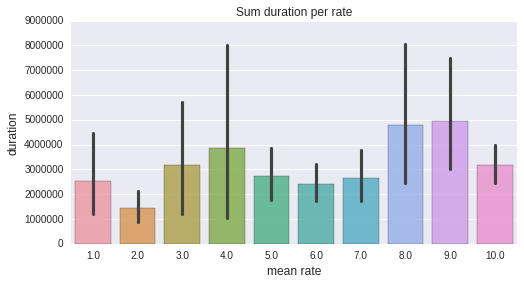

In [10]:
plt.figure(figsize=(8,4))
ax = sns.barplot(train_by_cont.rate.apply(np.round), train_by_cont.watch_duration, alpha=0.8)
plt.title("Sum duration per rate")
plt.ylabel('duration', fontsize=12)
plt.xlabel('mean rate', fontsize=12)
plt.show()

Видно, что в основном большая длительность просмотра у контента, который получает высокий рейтинг (хотя достаточно большие значения есть и на 4 баллах). Это дает основания предполагать, что чем больше длительность просмотра, тем выше оценку получит контент.

### Гистограмма количества фильмов по оценкам:

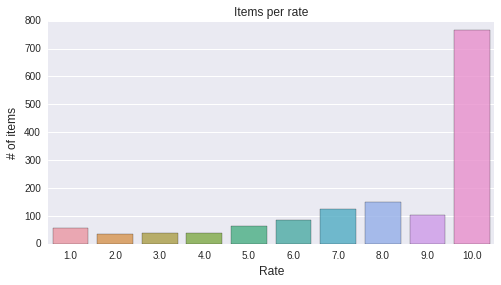

In [11]:
cont_byrate=train.groupby(['rate']).count().reset_index()

plt.figure(figsize=(8,4))
ax= sns.barplot(cont_byrate.rate, cont_byrate.item_id, alpha=0.8)
plt.title("Items per rate")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Rate', fontsize=12)
plt.show()

Абсолютное большинство фильмов получают высшую оценку.

### Гистограмма количества пользователей по числу просмотренных фильмов:

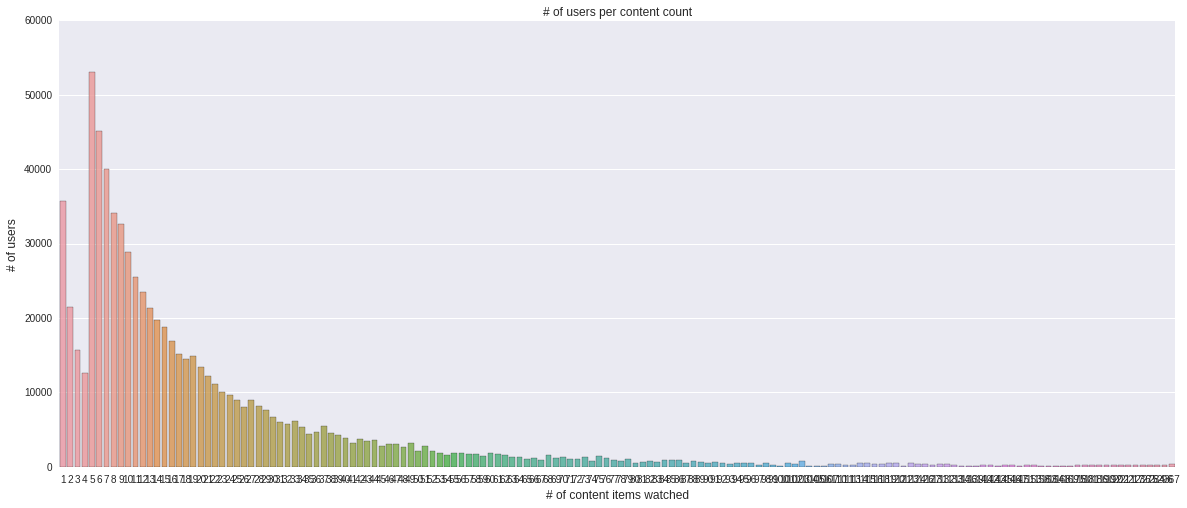

In [12]:
users_bycontent_count=train.groupby(['content_count_byuser']).count().reset_index()

plt.figure(figsize=(20,8))
ax = sns.barplot(users_bycontent_count.content_count_byuser, users_bycontent_count.user_id, alpha=0.8)
plt.title("# of users per content count")
plt.ylabel('# of users', fontsize=12)
plt.xlabel('# of content items watched', fontsize=12)
plt.show()

Видно, что большинство пользователей смотрят 1 или 5-10 различных контентов.

### Построение модели

Мы имеем матрицу оценок контента пользователями и матрицу длительностей просмотра, которую также можно использовать для построения недостающих оценок.
Построим модель рекомендаций контента на основе SVD-разложения. Мы получим матрицу, предсказывающую оценки пользователя для всех фильмов.
Будем брать фильмы, с максимальными оценками и считать, что именно их посмотрит пользователь. 

Проверим, что множества пользователей и контента в файлах пересекаются

In [13]:
#check how many test users are in train

test_users = set(list(test.user_id.values))
train_users = set(list(df_rates.user_id.values) + list(df_watch.user_id.values))
intersect_users = [u for u in test_users if u in train_users]

print 'test_users count: ',  len(test_users)
print 'train_users count: ',  len(train_users)
print 'intersect_users count: ',  len(intersect_users)

# check how many test items are in train

test_items = set(list(test.item_id.values))
train_items = set(list(df_rates.item_id.values) + list(df_watch.item_id.values))
intersect_items = [u for u in test_items if u in train_items]

print '\ntest_items count: ', len(test_items)
print 'train_items count: ', len(train_items)
print 'intersect_items count: ', len(intersect_items)

test_users count:  3662
train_users count:  108124
intersect_users count:  3662

test_items count:  4131
train_items count:  8759
intersect_items count:  4034


Около 100 фильмов из теста не встречаются в выборке за предыдущий месяц. Чтобы был шанс их предсказать, нужно заполнить оценки для них каким-нибудь средним значением для пользователя.

In [14]:
# merge data from watch and rates into train set
train = df_watch.merge(df_rates, how='outer', on=['user_id', 'item_id'])
train = train.groupby(['user_id', 'item_id'])['watch_duration', 'rate'].agg({'watch_duration': 'sum', 'rate': 'mean'}).reset_index()
train.count()

user_id           737517
item_id           737517
watch_duration    735158
rate                3795
dtype: int64

Построим матрицу пользователь-рейтинг для использования в SVD-разложении.
Создадим словарь id-индекс в матрице для маппинга id пользователей и контента.

In [15]:
user_ids = list(set(df_watch['user_id'].values.tolist() + df_rates['user_id'].values.tolist()))
item_ids = list(set(df_watch['item_id'].values.tolist() + df_rates['item_id'].values.tolist()))

USER_COUNT = len(user_ids)
ITEM_COUNT = len(item_ids)
print 'Total of unique users:', USER_COUNT
print 'Total of unique films:', ITEM_COUNT

user_dict = { user_id:i for i, user_id in enumerate(user_ids)}
item_dict = { item_id:i for i, item_id in enumerate(item_ids)}

Total of unique users: 108124
Total of unique films: 8759


Матрица пользователь-рейтинг

In [16]:
urm = np.zeros(shape=(USER_COUNT, ITEM_COUNT), dtype=np.float32)

Мы не всегда имеем информацию о рейтинге, но имеем дополнительно информацию о просмотрах. На гистограммах выше было видно, что чаще всего высокая длительность просмотра коррелирует с высоким рейтингом фильма. 
Будем использовать средние значения рейтинга, которые ставил данный пользователь, если он смотрел данный контент более 30 минут (условная минимальная длительность серии сериала). Если пользователь смотрел данный контент меньше 30 минут, скорее всего, он ему не понравился, поэтому проставим ему низкий рейтинг = 1.
Здесь 30 минут - параметр, который можно настраивать. 

Если у пользователя нет оценок для данного фильма, будем использовать глобальное среднее.

In [17]:
# set average rates for every user
# if a user doesn't have any rates then set the global average rate for him

global_avg = df_rates['rate'].mean()
print 'Global average: ', global_avg
avg_rates = df_rates.groupby(['user_id'])[['rate']].mean()
print 'Users with own rates: ', avg_rates.shape[0]

users_no_rates = [user_id for user_id in user_ids if not user_id in avg_rates.index]
global_avg_list = [global_avg for i in range(len(users_no_rates))]

avg_rates_for_users_with_no_rates = pd.DataFrame({'user_id': users_no_rates, 'rate': global_avg_list})
avg_rates_for_users_with_no_rates.set_index('user_id', inplace=True)
print 'Users with fake rates: ', avg_rates_for_users_with_no_rates.shape[0]

avg_rates = avg_rates.append(avg_rates_for_users_with_no_rates)

Global average:  8.35230566535
Users with own rates:  1218
Users with fake rates:  106906


In [18]:
# Set explicit rates to the matrix
for index, row in df_rates.iterrows():
    i = user_dict[row['user_id']]
    j = item_dict[row['item_id']]
    urm[i,j] = row['rate']
    
# Set implicit rates based on watched content and user's average rate
for index, row in df_watch.iterrows():
    i = user_dict[row['user_id']]
    j = item_dict[row['item_id']]
    if urm[i,j] == 0:
        urm[i,j] = 1 if row['watch_duration'] < 30*60 else avg_rates.loc[row['user_id']]['rate']

Для SVD-разложения пришлось использовать sparsesvd, так как при обычном разложении не хватало памяти. По той же причине функция computeSparseSVD возвращает не полную матрицу предсказанных оценок, а две части разложения.

In [19]:
urm_csr = csc_matrix(urm, dtype=np.float32)

In [20]:
# compute SVD from user-rate matrix, k is a parameter
def computeSVD(urm, k):
    U, sigma, Vt = svds(urm, k = 50)
    sigma = np.diag(sigma)
    prediction_matrix = np.dot(np.dot(U, sigma), Vt)
    return prediction_matrix

def computeSparseSVD(urm, K):
    U, s, Vt = sparsesvd(urm, K)
    sigma = np.diag(s)
    U = csr_matrix(np.transpose(U), dtype=np.float32)
    S = csr_matrix(sigma, dtype=np.float32)
    Vt = csr_matrix(Vt, dtype=np.float32)
    SVt = S*Vt
#     prediction_matrix = np.dot(U.T, np.dot(sigma, Vt))
#     return prediction_matrix

    return U, SVt

Функция получения рекомендаций: возвращает указанное число рекомендованных фильмов с наибольшим рейтингом, кроме тех, которые пользователь уже смотрел или оценивал. 
Предполагается, что большая часть контента - фильмы (это можно предположить, глядя на гистограмму длительностей просмотра, где есть скопление значений в районе 1,5-2 часовой длительности). Для сериалов, скорее всего, этот подход не будет правильным.

In [21]:
def recommend_for_user(U, SVt, user_id, user_seen_items, num_recommendations=5, verbose=False):
    rates = U[user_dict[user_id], :]*SVt
    # get predictions
    estimated_rates = rates.todense()
    recommend_df = pd.DataFrame({'item_id':item_ids})
    recommend_df.set_index('item_id', inplace=True)
    for index, row in recommend_df.iterrows():
        recommend_df.at[index, 'rate'] = estimated_rates[0, item_dict[index]]
    
    # recommend the highest rated content that the user hasn't seen/rated yet
    new_recommend = (recommend_df.loc[~recommend_df.index.isin(user_seen_items['item_id'])]
                    .sort_values('rate', ascending = False)
                    .iloc[:num_recommendations])
       
    if (verbose):
        print 'User {0} has already seen/rated {1} content items.'.format(user_id, user_seen_items.shape[0])
        print 'Recommending the highest {0} predicted ratings for content not seen/rated:'.format(num_recommendations)
        print new_recommend

    return new_recommend.index.values

Получение предсказаний для пользователей из тестовой выборки. Число предсказаний, которые хотим получить на следующие 2 недели берем равным половине от просмотренного пользователем за прошлый месяц.

In [22]:
def get_predictions(U, SVt, test_set):
    test_user_ids = test_set.user_id.unique().tolist()
    predictions_df = pd.DataFrame(columns=['user_id', 'item_id'], dtype='int32')
    for uid in test_user_ids:
        # get content user has already seen/rated
        user_seen_items = train[(train.user_id == uid) & (train.watch_duration > 0)]
        # predict for 2 weeks, so take 0.5 of total seen items in previous month
        predictions = recommend_for_user(U, SVt, uid, user_seen_items, int(round(user_seen_items.shape[0]/2)), False)
        predictions_df = predictions_df.append(pd.DataFrame({'user_id': uid, 'item_id': predictions}, dtype='int32'))

    return predictions_df

В качестве метрики точности будем рассчитывать F-меру:

In [23]:
def prediction_Fscore(predict_items, test_items):
    intersect_count = len([i for i in predict_items if i in test_items])
    if intersect_count == 0:
        return 0;
    #print ('intersect_count:', intersect_count)
    precision = float(intersect_count)/len(predict_items)
    recall = float(intersect_count)/len(test_items)
    if (precision + recall) > 0:
        Fscore = 2*precision*recall/(precision + recall)
    else:
        Fscore = 0
    return Fscore

In [24]:
def get_total_Fscore(test_set, validation_set):
    test_user_ids = test_set.user_id.unique().tolist()
    Fscores = []
    for uid in test_user_ids:
        items_seen_count = train[(train.user_id == uid) & (train.watch_duration > 0)].shape[0]
        # predict for 2 weeks, so take 0.5 of total seen items in previous month
        predictions = recommend_for_user(U, SVt, uid, train[(train.user_id == uid) & (train.watch_duration > 0)], int(round(items_seen_count/2)), False)
        answer = validation_set[validation_set.user_id == uid]['item_id'].values
        Fscore = prediction_Fscore(predictions, answer)
        Fscores.append(Fscore)

    Fscore_mean = np.mean(Fscores)
    print 'F score: ', Fscore_mean
    return Fscore_mean

In [25]:
def write_predictions(predictions_df, filename):
    predictions_df[['user_id', 'item_id']].astype(int).to_csv(filename, index=False)

Пример предсказания для 1 id пользователя:

In [26]:
user_id_test = -231141499

U, SVt = computeSparseSVD(urm_csr, 50)
predictions_df = get_predictions(U, SVt, pd.DataFrame({'user_id': [user_id_test]}, dtype='int32'))
answer = test[test.user_id == user_id_test]['item_id'].values
Fscore = prediction_Fscore(predictions_df.item_id, answer)
print 'F score: ', Fscore
write_predictions(predictions_df, 'data/prediction1.csv')

F score:  0.037037037037


Подбор параметра SVD-разложения k - количество признаков в матрицах SVD-разложения, которые мы используем.

In [27]:
train_set, test_set = train_test_split(test, test_size=0.33, random_state=42)
SVD_params = [20, 50, 100, 200]
fs = []
for k in SVD_params:
    U, SVt = computeSparseSVD(urm_csr, k)
    Fscore = get_total_Fscore(train_set, test)
    fs.append(Fscore)

F score:  0.0275499146363
F score:  0.0287547016506
F score:  0.0285397419541
F score:  0.0259074681333


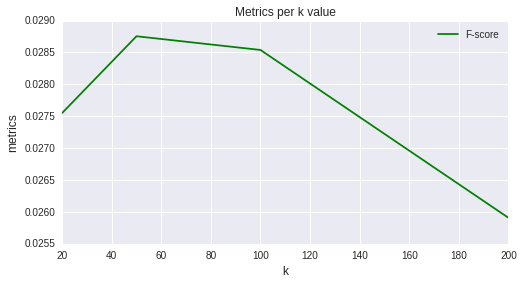

In [28]:
plt.figure(figsize=(8,4))
plt.plot(SVD_params, fs, 'g', label="F-score")
plt.legend()
plt.title("Metrics per k value")
plt.ylabel('metrics', fontsize=12)
plt.xlabel('k', fontsize=12)

In [33]:
print 'Max F-score:', max(fs)

Max F-score: 0.0287547016506


Оценка F-меры на отложенной выборке из теста:

In [41]:
test_Fscore = get_total_Fscore(test_set, test)

('F score: ', 0.028397674549549803)


Наибольшее значение F-мера принимает при k=50. 
F-мера все равно получилась очень маленькой. Можно было бы попробовать изменить алгоритм заполнения недостающих оценок контента, варьировать порог длительности просмотра, при которой мы добавляем в качестве рейтинга средний рейтинг пользователя. 
Также можно было бы попробовать обучить простую регрессию на признаках (длительность просмотра, число контента), которая предсказывала бы рейтинг для пользователя и контента.

Также был вариант построения рекомендательной системы на базе коллаборативной фильтрации по пользователям (посколько в выборке есть новый фильмы). (На реализацию, к сожалению, не хватило времени). План построения модели был следующий:
1. Для каждого пользователя:

    1.1. Построить вектор оценок всех фильмов.
    
    1.2. Для просмотренных, но не оцененных фильмов, заполнить средним рейтингом по пользователю.
    
2. Составить матрицу похожести пользователи-пользователи. В качестве меры схожести использовать косинусную меру для векторов из п.1.

Для построения рекомендаций:
1. Для каждого фильма, который не смотрел пользователь:

    1.1. Выбрать пользователей, которые смотрели/оценивали этот фильм.
    
    1.2. Найти k ближайший по косинусной мере пользователей.
    
    1.3. Посчитать взвешенную оценку по пользователям $$\sum_{i=1}^{k}Cos(u_i, u)*rate(u_i)$$

2. Выбрать m фильмов с максимальным рейтингом.